In [1]:
import pandas as pd
from functools import reduce
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt
import upsetplot
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
filename_dict = {
    "white_british": {
        "gsea": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/white_british/gsea_enrich.csv",
        "kegg": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/white_british/kegg_enrich.csv"
        },
    "white_british_male": {
        "gsea": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/white_british_male/gsea_enrich.csv",
        "kegg": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/white_british_male/kegg_enrich.csv"
        },
    "white_british_female": {
        "gsea": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/white_british_female/gsea_enrich.csv",
        "kegg": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/white_british_female/kegg_enrich.csv"
        },
    "post_menopause": {
        "gsea": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/post_menopause/gsea_enrich.csv",
        "kegg": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/post_menopause/kegg_enrich.csv"
        },
    "pre_menopause": {
        "gsea": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/pre_menopause/gsea_enrich.csv",
        "kegg": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/kegg_results/high_bmi/pre_menopause/kegg_enrich.csv"
        },
    "lifestyle_regressed": {
        "gsea": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/bmi_genes_lifestyle_regressed_out/gsea_enrich_high_bmi.csv",
        "kegg": "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/bmi_genes_lifestyle_regressed_out/kegg_enrich_high_bmi.csv"
        }
}

In [18]:
def set_add(a,b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersect_counts(include_sets, exclude_sets):
    intersect_set = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_set] + exclude_sets
        intersect_set = reduce(set_subtract, exclude_sets)
    return len(intersect_set), intersect_set

def get_ontology_set(filename, ontology_subtype):
    df = pd.read_csv(filename)
    # filter for subtype
    if ontology_subtype:
        df = df.loc[df["ONTOLOGY"]==ontology_subtype]
    return set(df["ID"])


def get_upset_df(group_names, ontology_type, ontology_subtype):
    enrich_set_dict = {group: get_ontology_set(filename_dict[group][ontology_type], ontology_subtype) for group in group_names}
    enrich_boolean_dict = {gn:[] for gn in group_names}
    counts = []
    sets = []
    for i in range(1, len(group_names) + 1):
        all_combos = list(combinations(group_names, i))
        for combos in all_combos:
            include_combos = combos
            exclude_combos = [ln for ln in group_names if ln not in include_combos]
            include_sets = [enrich_set_dict[c] for c in include_combos]
            exclude_sets = [enrich_set_dict[c] for c in exclude_combos]
            ics = get_intersect_counts(include_sets, exclude_sets)
            counts.append(ics[0])
            sets.append(ics[1])
            for c in include_combos:
                enrich_boolean_dict[c].append(True)
            for c in exclude_combos:
                enrich_boolean_dict[c].append(False)
    enrich_boolean_dict["counts"] = counts
    enrich_boolean_dict["sets"] = sets
    df = pd.DataFrame(enrich_boolean_dict)
    return df.set_index(group_names)

In [22]:
def save_upset_plot(upset_df, figsize, save_file):
    pdf = PdfPages(save_file)

    upset_df_filtered = upset_df.loc[upset_df.counts>0]
    fig = plt.figure(figsize=figsize)
    upsetplot.plot(upset_df_filtered.counts, fig=fig, element_size=None, show_counts=True)
    
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return upset_df_filtered

# KEGG

In [23]:
upset_df_kegg = get_upset_df(list(filename_dict.keys()), "kegg", "")

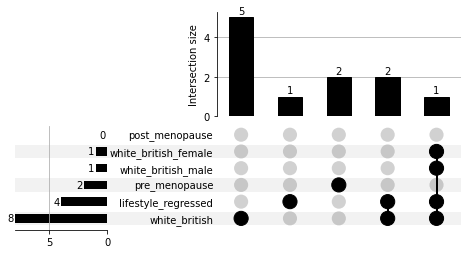

In [24]:
save_file_kegg = "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/figures/upset_plot/kegg.pdf"

upset_df_kegg_filtered = save_upset_plot(upset_df_kegg, (8,4), save_file_kegg)

# GSEA Molecular Function (MF)

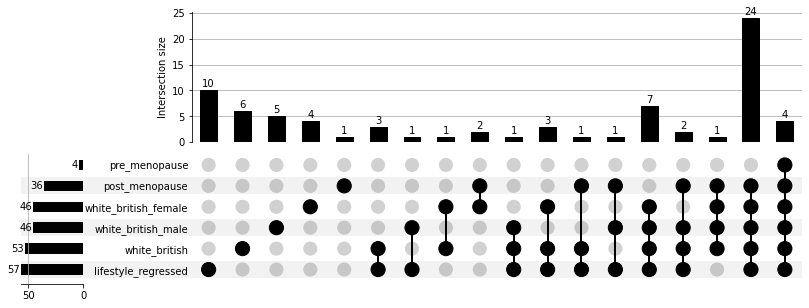

In [26]:
upset_df_mf = get_upset_df(list(filename_dict.keys()), "gsea", "MF")

save_file_mf = "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/figures/upset_plot/gsea_mf.pdf"

upset_df_mf_filtered = save_upset_plot(upset_df_mf, (14,5), save_file_mf)

# GSEA Biological Process (BP)

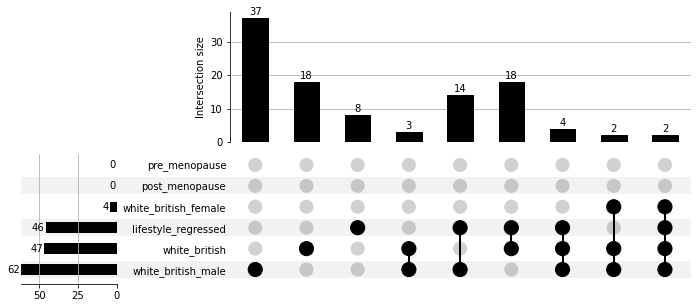

In [30]:
upset_df_bp = get_upset_df(list(filename_dict.keys()), "gsea", "BP")

save_file_bp = "/data5/deepro/ukbiobank/analysis/bmi_project/bmi_genes_enrichment/data/figures/upset_plot/gsea_bp.pdf"

upset_df_bp_filtered = save_upset_plot(upset_df_bp, (12,5), save_file_bp)